In [17]:
import openpyxl
import numpy as np
from sklearn import preprocessing

## Abrir Excel con Datos
file_train = 'CREDITRISK_RAW.xlsx'
wb = openpyxl.load_workbook(file_train)
sheet = wb.get_sheet_by_name('Sheet1')
sheet = wb.active

# Forma matriz para contener datos
columns = 20
rows = 2294
data_matrix = np.zeros(shape=(rows, columns))

# Columnas con datos no numericos, se deben pasar a labels numericos usando un LabelEncoder
non_numerical_columns = [1, 4, 5, 8, 18, 19]  ##
non_numerical_info = []
clases = []
clases_num_encode = []
features_names = []
empty_cell = sheet.cell(row=85, column=8).value  ## Ejemplo de celda vacia

for i in range(columns):
    j = 0
    column_i = []
    
    flag_non_numeric = False
    flag_append = True
    
    # Verificar si la columna es de datos no numericos
    if i in non_numerical_columns:
        flag_non_numeric = True
            
    for cellObj in sheet.columns[i]:
        if j > 0:
            if (cellObj.value == empty_cell) and (not flag_non_numeric):
            #if (cellObj.value == empty_cell):
                #flag_append = False
                column_i.append(0)
            else:
                column_i.append(cellObj.value)
        
        else:
            name = cellObj.value
            if i>0:
                features_names.append(name)
            print name
            
            
        j += 1
    
    
    if flag_non_numeric:
        le = preprocessing.LabelEncoder()
        le.fit(column_i)
        clases.append(list(le.classes_))
              
        n_clases = len(le.classes_)
        ordered_clases = np.linspace(0, n_clases - 1, n_clases)
        inverse_ordered = le.inverse_transform(list(ordered_clases.astype(int)))
        print ordered_clases
        print "Labels: ", str(inverse_ordered)
        
        
        non_numerical_info.append(sheet.cell(row=1, column=i+1).value)
        
        
        #enc = preprocessing.OneHotEncoder()
        #enc.fit(le.transform(column_i))
        #print enc.transform(le.transform(column_i)).toarray()
        
        
        
        # Encode de datos
        column_i = le.transform(column_i)
        
        # Encode de datos con OneHot Encode
        #column_i = enc.transform(le.transform(column_i)).toarray()
      
    if flag_append:
        data_matrix[:,i] = column_i
    else:
        print name + " no added"

   

ID
GENERO
[ 0.  1.  2.]
Labels:  [None u'F       ' u'M       ']
RENTA
EDAD
NIV_EDUC
[ 0.  1.  2.  3.  4.  5.  6.]
Labels:  [None u'        ' u'BAS     ' u'EUN     ' u'MED     ' u'TEC     '
 u'UNV     ']
E_CIVIL
[ 0.  1.  2.  3.  4.]
Labels:  [None u'CAS     ' u'SEP     ' u'SOL     ' u'VIU     ']
COD_OFI
COD_COM
CIUDAD
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.
  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.
  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.
  75.  76.  77.  78.]
Labels:  [None u'                ' u'ANCUD           ' u'ANGOL           '
 u'ANTOFAGASTA     ' u'ARICA           ' u'AYSEN           '
 u'CALAMA          ' u'CALBUCO         ' u'CALDERA         '
 u'CASABLANCA      ' u'CASTRO          ' u'CHILLAN         '
 u'CHUQUICAMATA    '

In [18]:
# Eliminar NaN values
from sklearn.preprocessing import Imputer

imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(data_matrix)

data_matrix = imp.transform(data_matrix)

In [19]:
## Calculo de caracteristicas

start_money_values = 9
finish_money_values = 12

"""
for i in range(12-9):
    for j in range(len(data_matrix[:,0])):
        sueldo = data_matrix[j,2]
        data_matrix[:,9+i] = data_matrix[:,9+i]/sueldo 
"""


'\nfor i in range(12-9):\n    for j in range(len(data_matrix[:,0])):\n        sueldo = data_matrix[j,2]\n        data_matrix[:,9+i] = data_matrix[:,9+i]/sueldo \n'

Feature ranking:
1. EDAD: 0.194186677644
2. GENERO: 0.128695279156
3. COD_COM: 0.104929220823
4. NIV_EDUC: 0.10000753742
5. COD_OFI: 0.0779653453565
6. Número de meses inactivo: 0.0637414767837
7. RENTA: 0.0484791767629
8. Crédito_4: 0.0465624067415
9. CIUDAD: 0.0445553837329
10. E_CIVIL: 0.0363974674536
11. numero de cuotas: 0.0352618162052
12. Monto solicitado: 0.0322026766939
13. Crédito_2: 0.0321815907385
14. Monto Deuda Promedio: 0.025654704717
15. Días de Mora: 0.0111432465398
16. Crédito_1: 0.0101117082209
17. Aval: 0.00610706896303
18. Crédito_3: 0.0018172160469


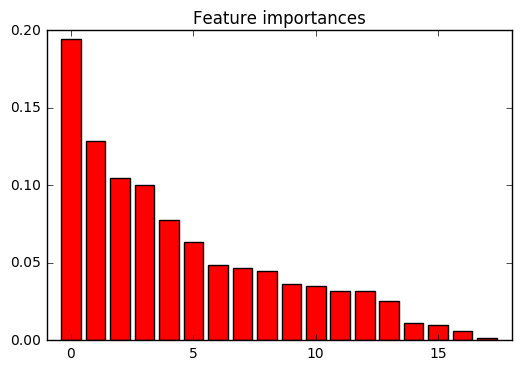

In [20]:
## Random Forest

%matplotlib inline
import matplotlib.pylab as plt

from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

N_features = (columns - 1) # Se resta ID y Label, PAGA o NO PAGA
X = data_matrix[:,1:N_features]
Y = data_matrix[:,columns - 1]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.5, random_state = True)


clf = RandomForestClassifier(n_estimators=650, max_depth=None, bootstrap = True, n_jobs = -1)
clf.fit(X_train, Y_train)
Y_pred = clf.predict_proba(X_test)


importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    
    #print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    print str(f+1)+". "+ features_names[indices[f]] + ": "+str(importances[indices[f]])
    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_test.shape[1]), importances[indices],
       color="r", align="center")
#plt.xticks(range(X_test.shape[1]), indices)
plt.xlim([-1, X_test.shape[1]])
plt.show()


In [21]:
from time import time
from sklearn import metrics
t0 = time()
pred = clf.predict(X_test)
test_time = time() - t0
print("test time:  %0.3fs" % test_time)

score = metrics.accuracy_score(Y_test, pred)
print score

test time:  0.820s
0.936355710549


In [144]:
#Graficos en base a las caracteristicas más importantes según Random Forest

class Histogram:
    
    def __init__(self, data_matrix, feature_index, name):
        self.name = name
        self.index = feature_index
        self.data = np.zeros(shape=(rows, 2))
        
        _columns = len(data_matrix[0,:])
        self.data[:,0] = data_matrix[:, self.index]
        self.data[:,1] = data_matrix[:, _columns - 1]
        
        _N_datos = len(self.data[:,0])
        self.convert_data = np.zeros( shape = (_N_datos, 2))
    
        _Paga = 1;
        _NoPaga = 0;

        self.paga_hist = []
        self.no_paga_hist = []

        for i in range(_N_datos):
            if self.data[i,1] == _Paga:
                self.paga_hist.append( self.data[i,0])
            else:
                self.no_paga_hist.append( self.data[i,0])
                
        self.discrete = False


    def set_bins(self, init_range, final_range, nbins):
        self.bins = plt.linspace(init_range, final_range, nbins)
        self.nbins = nbins
        self.xlims = [init_range-0.5, final_range+0.5]
        print self.bins
        
    def is_discrete(self, discrete):
        init_range = 0
        final_range = discrete+0.5 
        nbins = discrete + 1
        self.bins = plt.linspace(init_range, final_range, nbins)
        self.nbins = discrete
        self.bar_l = plt.linspace(0,discrete-1, discrete)
        self.xlims = [-0.5, discrete+0.5]
        self.discrete = True

    def set_xlim(self, array):
        self.xlims = array
    
    def hist(self):
        _paid = self.paga_hist
        _no_paid = self.no_paga_hist
            
        x = [_paid, _no_paid]
        self.histo = plt.hist(x, self.bins)
        plt.clf()

        _to_bar_1 = self.histo[0][0]
        _to_bar_2 = self.histo[0][1]

        # Create the general blog and the "subplots" i.e. the bars
        f, ax1 = plt.subplots(1, figsize=(10,5))

        # Set the bar width
        bar_width = 0.75
        bar_width = (self.bins[self.nbins-1] - self.bins[0])/(self.nbins)

        # positions of the left bar-boundaries
        #bar_l = [(i+1)*2.5 for i in range(len(_to_bar_1))] #+ self.bins[0]
        bar_l = [self.bins[0] + (i+1)*(self.bins[self.nbins-1] - self.bins[0])/(self.nbins) for i in range(len(_to_bar_1))]
  
        if (self.discrete == True):
            bar_width = 1.0
            bar_l = self.bar_l
        
        
  
    
        # positions of the x-axis ticks (center of the bars as bar labels)
        tick_pos = [i+(bar_width/2) for i in bar_l] #+ self.bins[0] 

        # Create a bar plot, in position bar_1
        ax1.bar(bar_l,
                # using the pre_score data
                _to_bar_1,
                # set the width
                width=bar_width,
                # with the label pre score
                label='Paga',
                # with alpha 0.5
                alpha=0.5,
                # with color
                color='#808000')

        # Create a bar plot, in position bar_1
        ax1.bar(bar_l,
                # using the mid_score data
                _to_bar_2,
                # set the width
                width=bar_width,
                # with pre_score on the bottom
                bottom=_to_bar_1,
                # with the label mid score
                label='No paga',
                # with alpha 0.5
                alpha=0.5,
                # with color
                color='#4b0082')
        

        
        # Set the label and legends
        ax1.set_ylabel("Cantidad")
        ax1.set_xlabel(self.name)
        ax1.set_xlim(self.xlims)
        plt.legend(loc='upper left')

        # Set a buffer around the edge
        #plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])
        
class double_graph:
    
    def __init__(self, index_1, index_2):
        self.index = index_1
        self.index2 = index_2
        self.data = np.zeros(shape=(rows, 3))
        
        _columns = len(data_matrix[0,:])
        self.data[:,0] = data_matrix[:, self.index]
        self.data[:,1] = data_matrix[:, _columns - 1]
        self.data[:,2] = data_matrix[:, self.index2]
        
        _N_datos = len(self.data[:,0])
        self.convert_data = np.zeros( shape = (_N_datos, 2))
    
        _Paga = 1;
        _NoPaga = 0;

        self.feature_1_paid = []
        self.feature_2_paid = []
        
        self.feature_1_nopaid = []
        self.feature_2_nopaid = []
        
        for i in range(_N_datos):
            if self.data[i,1] == _Paga:
                self.feature_1_paid.append(self.data[i,0]) 
                self.feature_2_paid.append(self.data[i,2])
            else:
                self.feature_1_nopaid.append(self.data[i,0])
                self.feature_2_nopaid.append(self.data[i,2]) 
    
    def plot(self):
        plt.figure()
        
        p_1_x = self.feature_1_paid 
        p_1_y = self.feature_2_paid 
        
        p_2_x = self.feature_1_nopaid 
        p_2_y = self.feature_2_nopaid 
        
        p1, = plt.plot(p_1_x, p_1_y, 'o', color='b', alpha = 0.4)
        p2, = plt.plot(p_2_x, p_2_y, 'o', color='y', alpha = 0.4) ##g^

        x1 = min(p_1_x)
        x2 = min(p_2_x)
        x3 = min([x1,x2])
        
        y1 = min(p_1_y)
        y2 = min(p_2_y)
        y3 = min([y1, y2])
        
        x11 = max(p_1_x)
        x22 = max(p_2_x)
        x33 = max([x11,x22])
        
        y11 = max(p_1_y)
        y22 = max(p_2_y)
        y33 = max([y11, y22])
        
        x_ = x3 - (x33 - x3)*0.10
        x_up = x33 + (x33 - x3)*0.10
        y_ = y3 - (y33 - y3)*0.10
        y_up = y33 + (y33 - y3)*0.10
        
        print [x_, x_up, y_, y_up]
        
        plt.axis([x_, x_up, y_, y_up])
        plt.xlabel(features_names[self.index-1])
        plt.ylabel(features_names[self.index2-1])

        
        
        plt.legend([ p1, p2], ["Paga" ,"No Paga"])


[ 20.          21.02272727  22.04545455  23.06818182  24.09090909
  25.11363636  26.13636364  27.15909091  28.18181818  29.20454545
  30.22727273  31.25        32.27272727  33.29545455  34.31818182
  35.34090909  36.36363636  37.38636364  38.40909091  39.43181818
  40.45454545  41.47727273  42.5         43.52272727  44.54545455
  45.56818182  46.59090909  47.61363636  48.63636364  49.65909091
  50.68181818  51.70454545  52.72727273  53.75        54.77272727
  55.79545455  56.81818182  57.84090909  58.86363636  59.88636364
  60.90909091  61.93181818  62.95454545  63.97727273  65.        ]


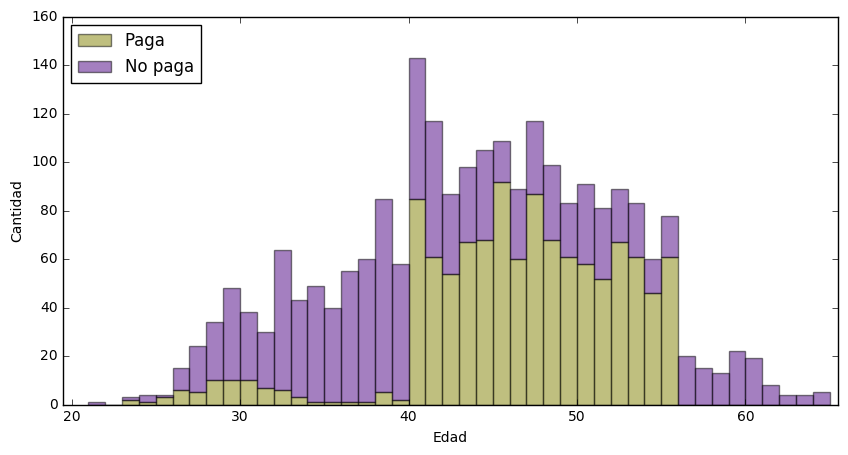

In [63]:
## EDAD ##
age_hist = Histogram(data_matrix, 3, "Edad")
age_hist.set_bins(20,65, 45) ## DE 20 a 60 años, 20 intervalos
age_hist.hist()

[   40000.           143157.89473684   246315.78947368   349473.68421053
   452631.57894737   555789.47368421   658947.36842105   762105.26315789
   865263.15789474   968421.05263158  1071578.94736842  1174736.84210526
  1277894.73684211  1381052.63157895  1484210.52631579  1587368.42105263
  1690526.31578947  1793684.21052632  1896842.10526316  2000000.        ]


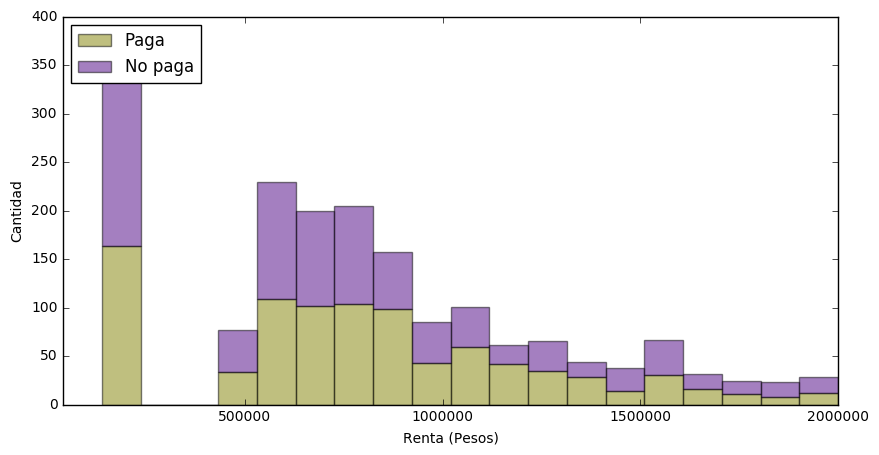

In [82]:
## RENTA ##
rent_hist = Histogram(data_matrix, 2, "Renta (Pesos)")
rent_hist.set_bins(40000, 2e6, 20)
rent_hist.hist()

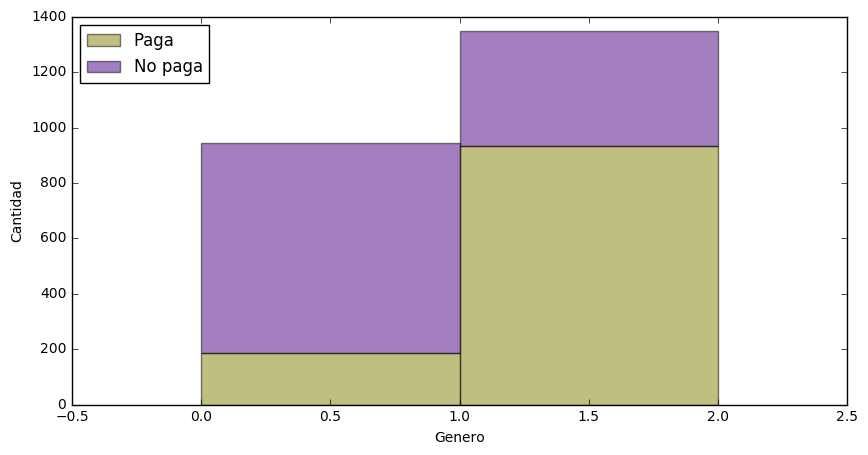

In [65]:
## GENERO ##
genre_hist = Histogram(data_matrix, 1, "Genero")
#rent_hist.set_bins(50000, 1e6, 10)
genre_hist.is_discrete(2)
genre_hist.hist()

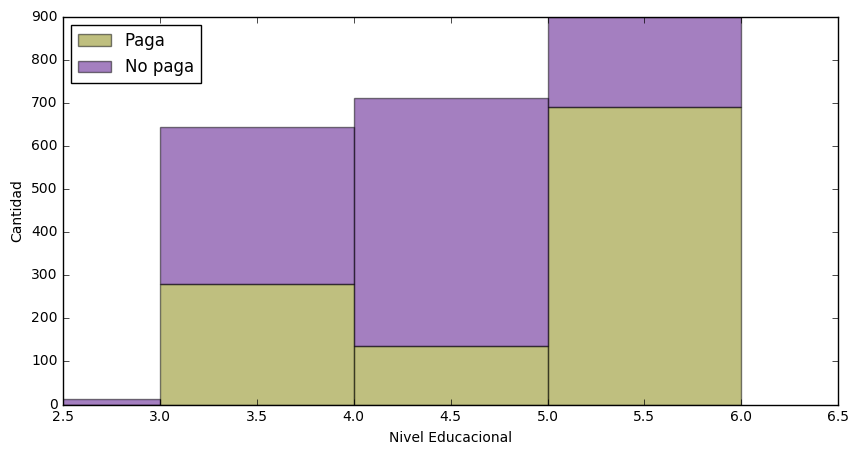

In [97]:
## NIVEL EDUCACIONAL ##
niv_ED_hist = Histogram(data_matrix, 4, "Nivel Educacional")
#rent_hist.set_bins(50000, 1e6, 10)
niv_ED_hist.is_discrete(6)
niv_ED_hist.set_xlim([2.5,6.5])
niv_ED_hist.hist()

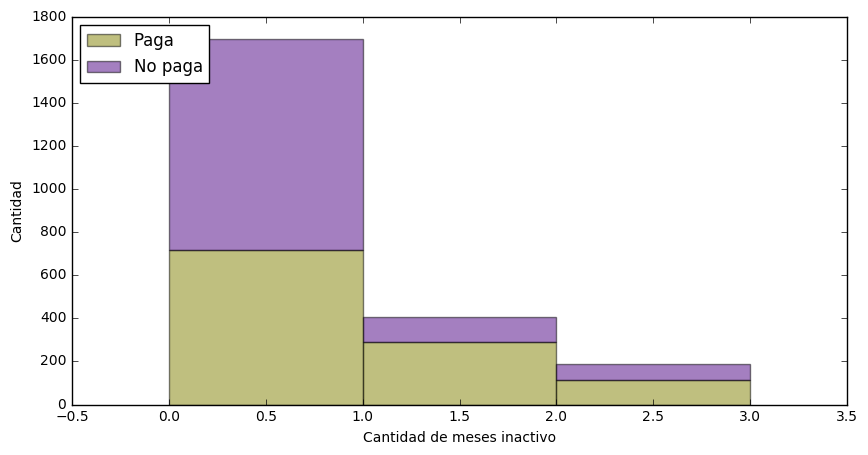

In [109]:
## CANTIDAD DE MESES INACTIVO ##
cod_com_hist = Histogram(data_matrix, 16, "Cantidad de meses inactivo")
#cod_com_hist.set_bins(0, 3, 3)
cod_com_hist.is_discrete(3)
cod_com_hist.hist()

[   0.            1.00334448    2.00668896    3.01003344    4.01337793
    5.01672241    6.02006689    7.02341137    8.02675585    9.03010033
   10.03344482   11.0367893    12.04013378   13.04347826   14.04682274
   15.05016722   16.05351171   17.05685619   18.06020067   19.06354515
   20.06688963   21.07023411   22.0735786    23.07692308   24.08026756
   25.08361204   26.08695652   27.090301     28.09364548   29.09698997
   30.10033445   31.10367893   32.10702341   33.11036789   34.11371237
   35.11705686   36.12040134   37.12374582   38.1270903    39.13043478
   40.13377926   41.13712375   42.14046823   43.14381271   44.14715719
   45.15050167   46.15384615   47.15719064   48.16053512   49.1638796
   50.16722408   51.17056856   52.17391304   53.17725753   54.18060201
   55.18394649   56.18729097   57.19063545   58.19397993   59.19732441
   60.2006689    61.20401338   62.20735786   63.21070234   64.21404682
   65.2173913    66.22073579   67.22408027   68.22742475   69.23076923
   70.2

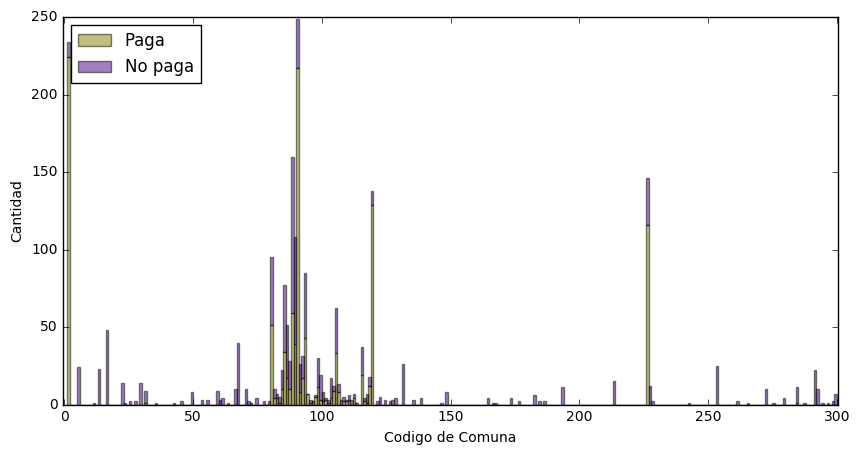

In [104]:
## COD_COM ##
cod_com_hist = Histogram(data_matrix, 7, "Codigo de Comuna")
cod_com_hist.set_bins(0, 300, 300)
cod_com_hist.hist()

[  0.           1.01265823   2.02531646   3.03797468   4.05063291
   5.06329114   6.07594937   7.08860759   8.10126582   9.11392405
  10.12658228  11.13924051  12.15189873  13.16455696  14.17721519
  15.18987342  16.20253165  17.21518987  18.2278481   19.24050633
  20.25316456  21.26582278  22.27848101  23.29113924  24.30379747
  25.3164557   26.32911392  27.34177215  28.35443038  29.36708861
  30.37974684  31.39240506  32.40506329  33.41772152  34.43037975
  35.44303797  36.4556962   37.46835443  38.48101266  39.49367089
  40.50632911  41.51898734  42.53164557  43.5443038   44.55696203
  45.56962025  46.58227848  47.59493671  48.60759494  49.62025316
  50.63291139  51.64556962  52.65822785  53.67088608  54.6835443
  55.69620253  56.70886076  57.72151899  58.73417722  59.74683544
  60.75949367  61.7721519   62.78481013  63.79746835  64.81012658
  65.82278481  66.83544304  67.84810127  68.86075949  69.87341772
  70.88607595  71.89873418  72.91139241  73.92405063  74.93670886
  75.949367

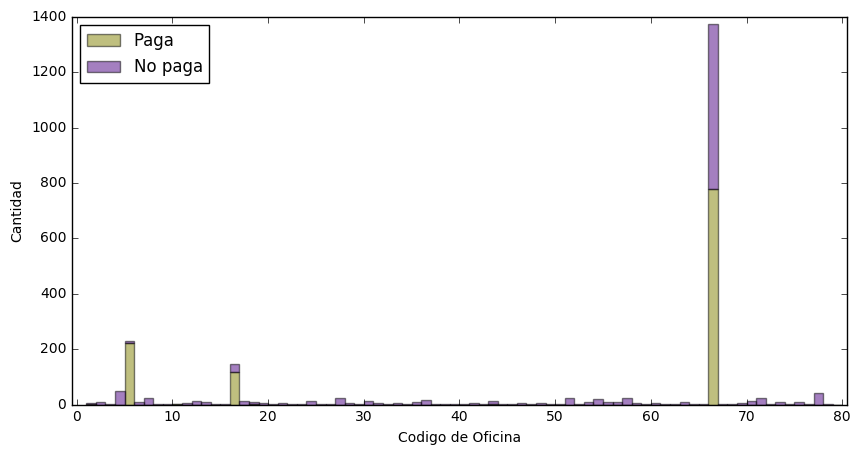

In [111]:
## COD_COM ##
cod_com_hist = Histogram(data_matrix, 8, "Codigo de Oficina")
cod_com_hist.set_bins(0, 80, 80)
cod_com_hist.hist()

[-0.60000000000000009, 6.5999999999999996, -0.20000000000000001, 2.2000000000000002]


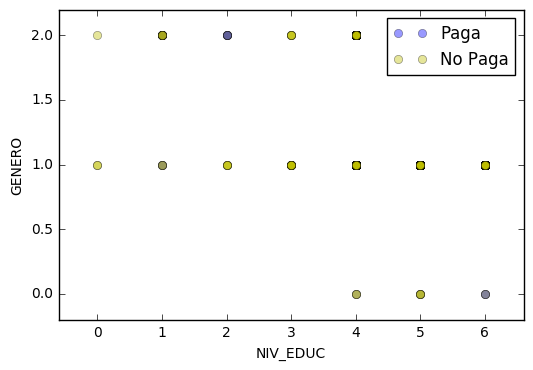

In [167]:
graph = double_graph(4,1)
graph.plot()

In [125]:
features_names

[u'GENERO',
 u'RENTA',
 u'EDAD',
 u'NIV_EDUC',
 u'E_CIVIL',
 u'COD_OFI',
 u'COD_COM',
 u'CIUDAD',
 u'Cr\xe9dito_1',
 u'Cr\xe9dito_2',
 u'Cr\xe9dito_3',
 u'Cr\xe9dito_4',
 u'Monto solicitado',
 u'D\xedas de Mora',
 u'Monto Deuda Promedio',
 u'N\xfamero de meses inactivo',
 u'numero de cuotas',
 u'Aval',
 u'PAGA']

In [14]:
data_matrix[:,1]

array([ 1.,  1.,  1., ...,  1.,  1.,  1.])